# Image Simulation with pyBSM

This notebook demonstrates how to use pyBSM to simulate the effects of individual and composite sensor degradations on imagery.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from pybsm import simulation
from pybsm.simulation import (
    CircularApertureSimulator,
    DefocusSimulator,
    DetectorSimulator,
    JitterSimulator,
    SystemOTFSimulator,
    TurbulenceApertureSimulator,
)

In [6]:
# Load the reference image
img_file_name = "data/M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff"
img = plt.imread(img_file_name)

# Create a RefImage object with ground sampling distance (GSD)
# The tank width is 319 cm and spans ~160 pixels in the image
ref_img = simulation.RefImage(img=img, gsd=(3.19 / 160.0))

# Automatically estimate sensor and scenario parameters for a given altitude
# This creates realistic sensor/scenario configurations without manual parameter tuning
altitude = 9000  # meters
sensor, scenario = ref_img.estimate_capture_parameters(altitude=altitude)

In [7]:
# Apply individual degradation effects
# Each simulator returns: (true_img, blur_img, noisy_img)
# - true_img: image converted to photoelectrons
# - blur_img: image after blurring and resampling (this is what will be displayed)
# - noisy_img: blur_img with noise added (None when add_noise=False)

# Jitter effect: image blur caused by platform vibration during exposure
jitter = JitterSimulator(sensor=sensor, scenario=scenario)
true_img, jitter_img_out, noisy_img = jitter.simulate_image(ref_img.img, gsd=ref_img.gsd)

# Circular aperture effect: diffraction blur from the circular lens aperture
circ_ap = CircularApertureSimulator(sensor=sensor, scenario=scenario)
true_img, circ_ap_img_out, noisy_img = circ_ap.simulate_image(ref_img.img, gsd=ref_img.gsd)

# Detector effect: blur caused by finite detector size and spacing
detector = DetectorSimulator(sensor=sensor, scenario=scenario)
true_img, detector_img_out, noisy_img = detector.simulate_image(ref_img.img, gsd=ref_img.gsd)

# Defocus effect: image blur from imperfect focus
defocus = DefocusSimulator(sensor=sensor, scenario=scenario)
true_img, defocus_img_out, noisy_img = defocus.simulate_image(ref_img.img, gsd=ref_img.gsd)

# Turbulence aperture effect: atmospheric turbulence causing wavefront distortions
turb_ap = TurbulenceApertureSimulator(sensor=sensor, scenario=scenario)
true_img, turb_ap_img_out, noisy_img = turb_ap.simulate_image(ref_img.img, gsd=ref_img.gsd)

# System-level simulation: combines all degradation effects plus sensor noise
system = SystemOTFSimulator(
    sensor=sensor,
    scenario=scenario,
    add_noise=True,  # Include photon noise and read noise
    rng=1,  # Random seed for reproducibility
    use_reflectance=True,  # Convert image to reflectance before simulation
    reflectance_range=np.array([0.05, 0.5]),  # Map pixel values to reflectance range
)
true_img, blur_img, system_out = system.simulate_image(ref_img.img, gsd=ref_img.gsd)

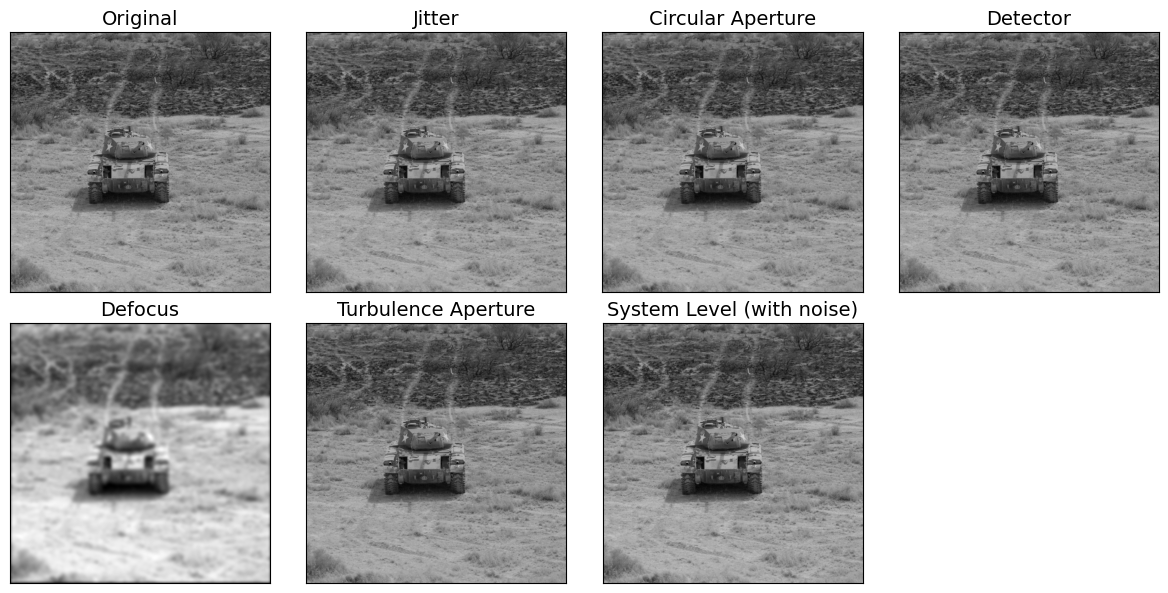

In [8]:
# Visualize the results
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()

# Display each image with its corresponding degradation effect
ax[0].imshow(ref_img.img, cmap="gray")
ax[1].imshow(jitter_img_out, cmap="gray")
ax[2].imshow(circ_ap_img_out, cmap="gray")
ax[3].imshow(detector_img_out, cmap="gray")
ax[4].imshow(defocus_img_out, cmap="gray")
ax[5].imshow(turb_ap_img_out, cmap="gray")
ax[6].imshow(system_out, cmap="gray")

# Add titles
fontsize = 14
ax[0].set_title("Original", fontsize=fontsize)
ax[1].set_title("Jitter", fontsize=fontsize)
ax[2].set_title("Circular Aperture", fontsize=fontsize)
ax[3].set_title("Detector", fontsize=fontsize)
ax[4].set_title("Defocus", fontsize=fontsize)
ax[5].set_title("Turbulence Aperture", fontsize=fontsize)
ax[6].set_title("System Level (with noise)", fontsize=fontsize)

# Remove empty subplot and clean up axes
ax[7].remove()
for _ax in ax:
    _ax.set_xticks([])
    _ax.set_yticks([])

plt.tight_layout()
plt.show()